# Дообучение Llama 2 на основе промтов-инструкций

Основная задача дообучения - научить модель извлекать пару (аспект - тональность) на основе подготовленных промтов. В папке есть отдельный файл с заранее подготовленными шаблонами промптами, который будет использоваться для обучения.

Исползуются данные SemEval 2014 Task 4, содержащие сам аспект, его категорию и тональность. В рамках данного эксперимента я буду извлекать только аспект/аспекты и его тональность.

Так как Llama 2 довольно большая модель, то обучать ее буду с помощью LoRa (из бтблиотеки peft) и в квантованном 8-ми битном варианте.

## Загрузка и подготовка датасета

In [1]:
#!g2.1
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [2]:
#!g2.1
from datasets import load_dataset
raw_datasets = load_dataset("alexcadillon/SemEval2014Task4", 'restaurants')
raw_datasets

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating trial split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

DatasetDict({
    trial: Dataset({
        features: ['sentenceId', 'text', 'aspectTerms', 'aspectCategories'],
        num_rows: 100
    })
    train: Dataset({
        features: ['sentenceId', 'text', 'aspectTerms', 'aspectCategories'],
        num_rows: 3041
    })
    test: Dataset({
        features: ['sentenceId', 'text', 'aspectTerms', 'aspectCategories'],
        num_rows: 800
    })
})

In [3]:
#!g2.1
sample = raw_datasets['train'][10]
sample

{'sentenceId': '296',
 'text': 'They did not have mayonnaise, forgot our toast, left out ingredients (ie cheese in an omelet), below hot temperatures and the bacon was so over cooked it crumbled on the plate when you touched it.',
 'aspectTerms': [{'term': 'toast',
   'polarity': 'negative',
   'from': '41',
   'to': '46'},
  {'term': 'mayonnaise', 'polarity': 'negative', 'from': '18', 'to': '28'},
  {'term': 'bacon', 'polarity': 'negative', 'from': '126', 'to': '131'},
  {'term': 'cheese', 'polarity': 'neutral', 'from': '73', 'to': '79'},
  {'term': 'ingredients', 'polarity': 'negative', 'from': '57', 'to': '68'},
  {'term': 'plate', 'polarity': 'neutral', 'from': '170', 'to': '175'},
  {'term': 'omelet', 'polarity': 'neutral', 'from': '86', 'to': '92'}],
 'aspectCategories': [{'category': 'food', 'polarity': 'negative'}]}

In [4]:
#!g2.1
template_name = "promts_template.json"
import random
import json
with open(template_name) as fp:
        template = json.load(fp)

def create_promts(instance):
    
    text = instance["text"]
    output_dict = {}
    num = random.randint(0,111)

    instruction = template[str(num)].format(
        input = f"{text}"
    )

    answers = []
    for item in instance['aspectTerms']:
        answers.append(f"{item['term']}: {item['polarity']}")
    answer_string = ', '.join(answers)
    
    output_string = f"{instruction} Aspects and their polarity: {answer_string}."
    
    instance["instruction"] = instruction
    instance["input"] = instance["text"]
    instance["output"] = output_string
    instance["answer"] = answer_string
    
    return instance


In [5]:
#!g2.1
create_promts(sample)

{'sentenceId': '296',
 'text': 'They did not have mayonnaise, forgot our toast, left out ingredients (ie cheese in an omelet), below hot temperatures and the bacon was so over cooked it crumbled on the plate when you touched it.',
 'aspectTerms': [{'term': 'toast',
   'polarity': 'negative',
   'from': '41',
   'to': '46'},
  {'term': 'mayonnaise', 'polarity': 'negative', 'from': '18', 'to': '28'},
  {'term': 'bacon', 'polarity': 'negative', 'from': '126', 'to': '131'},
  {'term': 'cheese', 'polarity': 'neutral', 'from': '73', 'to': '79'},
  {'term': 'ingredients', 'polarity': 'negative', 'from': '57', 'to': '68'},
  {'term': 'plate', 'polarity': 'neutral', 'from': '170', 'to': '175'},
  {'term': 'omelet', 'polarity': 'neutral', 'from': '86', 'to': '92'}],
 'aspectCategories': [{'category': 'food', 'polarity': 'negative'}],
 'instruction': 'Sentence: They did not have mayonnaise, forgot our toast, left out ingredients (ie cheese in an omelet), below hot temperatures and the bacon was s

In [6]:
#!g2.1
%pip install "dill<0.3.5"

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.9/86.9 kB 785.3 kB/s eta 0:00:00a 0:00:01
  Attempting uninstall: dill
    Found existing installation: dill 0.3.7
    Uninstalling dill-0.3.7:
      Successfully uninstalled dill-0.3.7
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
multiprocess 0.70.15 requires dill>=0.3.7, but you have dill 0.3.4 which is incompatible.

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [7]:
#!g2.1
instruction_dataset = raw_datasets.map(create_promts)
instruction_dataset

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/3041 [00:00<?, ? examples/s]

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

DatasetDict({
    trial: Dataset({
        features: ['sentenceId', 'text', 'aspectTerms', 'aspectCategories', 'instruction', 'input', 'output', 'answer'],
        num_rows: 100
    })
    train: Dataset({
        features: ['sentenceId', 'text', 'aspectTerms', 'aspectCategories', 'instruction', 'input', 'output', 'answer'],
        num_rows: 3041
    })
    test: Dataset({
        features: ['sentenceId', 'text', 'aspectTerms', 'aspectCategories', 'instruction', 'input', 'output', 'answer'],
        num_rows: 800
    })
})

In [8]:
#!g2.1
from datasets import concatenate_datasets
concat_dataset = concatenate_datasets([instruction_dataset['train'], instruction_dataset['test'], instruction_dataset['trial']])
concat_dataset

Dataset({
    features: ['sentenceId', 'text', 'aspectTerms', 'aspectCategories', 'instruction', 'input', 'output', 'answer'],
    num_rows: 3941
})

In [9]:
#!g2.1
def tokenize(prompt, add_eos_token=True):
    result = tokenizer(
        prompt,
        truncation=True,
        max_length=cutoff_len,
        padding=False,
        return_tensors=None,
    )
    if (
        result["input_ids"][-1] != tokenizer.eos_token_id
        and len(result["input_ids"]) < cutoff_len
        and add_eos_token
    ):
        result["input_ids"].append(tokenizer.eos_token_id)
        result["attention_mask"].append(1)

    result["labels"] = result["input_ids"].copy()

    return result

def generate_and_tokenize_prompt(data_point):
    full_prompt = prompter.generate_prompt(
        data_point["instruction"],
        data_point["output"],
    )
    tokenized_full_prompt = tokenize(full_prompt)
    user_prompt = prompter.generate_prompt(
            data_point["instruction"]
        )
    tokenized_user_prompt = tokenize(user_prompt, add_eos_token=False)
    user_prompt_len = len(tokenized_user_prompt["input_ids"])

    tokenized_full_prompt["labels"] = [
        -100
    ] * user_prompt_len + tokenized_full_prompt["labels"][
        user_prompt_len:
    ]  # could be sped up, probably
    return tokenized_full_prompt

In [10]:
#!g2.1
from transformers import AutoTokenizer, AutoModelForCausalLM
import numpy as np

tokenizer = AutoTokenizer.from_pretrained("huggyllama/llama-7b")
tokenizer.pad_token_id = 0 

tokenizer_config.json:   0%|          | 0.00/700 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/411 [00:00<?, ?B/s]

In [11]:
#!g2.1
from typing import Union

class Prompter(object):
    
    def generate_prompt(
        self,
        instruction: str,
        label: Union[None, str] = None,
    ) -> str:     

        res = f"{instruction}\nAnswer: "
               
        if label:
            res = f"{res}{label}"
         
        return res


    def get_response(self, output: str) -> str:
        return output.split("Answer:")[1].strip()
    
prompter = Prompter()

In [12]:
#!g2.1
cutoff_len=512
train_val = concat_dataset.train_test_split(test_size=0.03, shuffle=True, seed=5)
train_data = (train_val["train"].shuffle().map(generate_and_tokenize_prompt))
val_data = (train_val["test"].shuffle().map(generate_and_tokenize_prompt))

Map:   0%|          | 0/3822 [00:00<?, ? examples/s]

Map:   0%|          | 0/119 [00:00<?, ? examples/s]

## Загрузка модели и LoRa

In [13]:
#!g2.1
import os
import sys
from typing import List

os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [14]:
#!g2.1
%pip install fire

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [15]:
#!g2.1
%pip install -q bitsandbytes accelerate loralib

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2023.6.0 requires fsspec==2023.6.0, but you have fsspec 2023.10.0 which is incompatible.

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [16]:
#!g2.1
%pip install -q git+https://github.com/huggingface/peft.git

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2023.6.0 requires fsspec==2023.6.0, but you have fsspec 2023.10.0 which is incompatible.

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [17]:
#!g2.1
%pip install sentencepiece

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [18]:
#!g2.1
import torch
model = AutoModelForCausalLM.from_pretrained("baffo32/decapoda-research-llama-7B-hf", load_in_8bit=True,torch_dtype=torch.float16)

config.json:   0%|          | 0.00/428 [00:00<?, ?B/s]

pytorch_model.bin.index.json:   0%|          | 0.00/25.5k [00:00<?, ?B/s]

pytorch_model-00001-of-00033.bin:   0%|          | 0.00/405M [00:00<?, ?B/s]

pytorch_model-00002-of-00033.bin:   0%|          | 0.00/405M [00:00<?, ?B/s]

pytorch_model-00003-of-00033.bin:   0%|          | 0.00/405M [00:00<?, ?B/s]

pytorch_model-00004-of-00033.bin:   0%|          | 0.00/405M [00:00<?, ?B/s]

pytorch_model-00005-of-00033.bin:   0%|          | 0.00/405M [00:00<?, ?B/s]

pytorch_model-00006-of-00033.bin:   0%|          | 0.00/405M [00:00<?, ?B/s]

pytorch_model-00007-of-00033.bin:   0%|          | 0.00/405M [00:00<?, ?B/s]

pytorch_model-00008-of-00033.bin:   0%|          | 0.00/405M [00:00<?, ?B/s]

pytorch_model-00009-of-00033.bin:   0%|          | 0.00/405M [00:00<?, ?B/s]

pytorch_model-00010-of-00033.bin:   0%|          | 0.00/405M [00:00<?, ?B/s]

pytorch_model-00011-of-00033.bin:   0%|          | 0.00/405M [00:00<?, ?B/s]

pytorch_model-00012-of-00033.bin:   0%|          | 0.00/405M [00:00<?, ?B/s]

pytorch_model-00013-of-00033.bin:   0%|          | 0.00/405M [00:00<?, ?B/s]

pytorch_model-00014-of-00033.bin:   0%|          | 0.00/405M [00:00<?, ?B/s]

pytorch_model-00015-of-00033.bin:   0%|          | 0.00/405M [00:00<?, ?B/s]

pytorch_model-00016-of-00033.bin:   0%|          | 0.00/405M [00:00<?, ?B/s]

pytorch_model-00017-of-00033.bin:   0%|          | 0.00/405M [00:00<?, ?B/s]

pytorch_model-00018-of-00033.bin:   0%|          | 0.00/405M [00:00<?, ?B/s]

pytorch_model-00019-of-00033.bin:   0%|          | 0.00/405M [00:00<?, ?B/s]

pytorch_model-00020-of-00033.bin:   0%|          | 0.00/405M [00:00<?, ?B/s]

pytorch_model-00021-of-00033.bin:   0%|          | 0.00/405M [00:00<?, ?B/s]

pytorch_model-00022-of-00033.bin:   0%|          | 0.00/405M [00:00<?, ?B/s]

pytorch_model-00023-of-00033.bin:   0%|          | 0.00/405M [00:00<?, ?B/s]

pytorch_model-00024-of-00033.bin:   0%|          | 0.00/405M [00:00<?, ?B/s]

pytorch_model-00025-of-00033.bin:   0%|          | 0.00/405M [00:00<?, ?B/s]

pytorch_model-00026-of-00033.bin:   0%|          | 0.00/405M [00:00<?, ?B/s]

pytorch_model-00027-of-00033.bin:   0%|          | 0.00/405M [00:00<?, ?B/s]

pytorch_model-00028-of-00033.bin:   0%|          | 0.00/405M [00:00<?, ?B/s]

pytorch_model-00029-of-00033.bin:   0%|          | 0.00/405M [00:00<?, ?B/s]

pytorch_model-00030-of-00033.bin:   0%|          | 0.00/405M [00:00<?, ?B/s]

pytorch_model-00031-of-00033.bin:   0%|          | 0.00/405M [00:00<?, ?B/s]

pytorch_model-00032-of-00033.bin:   0%|          | 0.00/405M [00:00<?, ?B/s]

pytorch_model-00033-of-00033.bin:   0%|          | 0.00/524M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/33 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [19]:
#!g2.1
from peft import (
    LoraConfig,
    get_peft_model,
    get_peft_model_state_dict,
    prepare_model_for_int8_training,
    set_peft_model_state_dict,
)

In [20]:
#!g2.1
model = prepare_model_for_int8_training(model)

In [21]:
#!g2.1
lora_r=64
lora_alpha= 64
lora_dropout= 0.05
lora_target_modules = ["q_proj", "v_proj", "k_proj", "o_proj",]

In [22]:
#!g2.1
config = LoraConfig(
        r=lora_r,
        lora_alpha=lora_alpha,
        target_modules=lora_target_modules,
        lora_dropout=lora_dropout,
        bias="none",
        task_type="CAUSAL_LM",
    )

model = get_peft_model(model, config)
model.print_trainable_parameters()

trainable params: 67,108,864 || all params: 6,805,524,480 || trainable%: 0.986093932910223


In [23]:
#!g2.1
import warnings
warnings.filterwarnings("ignore")

In [24]:
#!g2.1
import fire
import transformers

In [25]:
#!g2.1
trainer = transformers.Trainer(
    model=model, 
    train_dataset=train_data,
    eval_dataset=val_data,
    #compute_metrics = compute_metrics,
    args=transformers.TrainingArguments(
        per_device_train_batch_size=8, 
        gradient_accumulation_steps=4,
        warmup_steps=2, 
        num_train_epochs=1,
        max_steps=300, 
        learning_rate=3e-4, 
        fp16=True,
        logging_steps=40, 
        save_strategy="no",
        optim="adamw_torch",
        evaluation_strategy="steps",
        eval_steps=40,
        output_dir='Llama2_instr_ABSA',
        #report_to="wandb",
        #push_to_hub = True
        
    ),
    data_collator=transformers.DataCollatorForSeq2Seq(
            tokenizer, pad_to_multiple_of=8, return_tensors="pt", padding=True
        ),
)
model.config.use_cache = False  # silence the warnings. Please re-enable for inference!


trainer.train()

2023-11-24 19:47:44.220134: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss
40,0.132700,0.030083
80,0.038400,0.025419
120,0.033300,0.025349
160,0.022400,0.024690
200,0.020900,0.022796
240,0.020200,0.022269
280,0.013000,0.025286


TrainOutput(global_step=300, training_loss=0.038281059314807256, metrics={'train_runtime': 1865.8526, 'train_samples_per_second': 5.145, 'train_steps_per_second': 0.161, 'total_flos': 5.164360276180992e+16, 'train_loss': 0.038281059314807256, 'epoch': 2.51})

## Оценка качества

Для оценки буду сопоставлять сгенерированный текст и исходный ответ, в качестве метрики возьму exact match на уровне единицы корпуса текстов. В данном датасете - это отдельное предложение

In [26]:
#!g2.1
%pip install evaluate

Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for urllib3<1.27,>=1.21.1 from https://files.pythonhosted.org/packages/b0/53/aa91e163dcfd1e5b82d8a890ecf13314e3e149c05270cc644581f77f17fd/urllib3-1.26.18-py2.py3-none-any.whl.metadata
  Using cached urllib3-1.26.18-py2.py3-none-any.whl.metadata (48 kB)
  Using cached charset_normalizer-2.0.12-py3-none-any.whl (39 kB)
  Obtaining dependency information for dill from https://files.pythonhosted.org/packages/f5/3a/74a29b11cf2cdfcd6ba89c0cecd70b37cd1ba7b77978ce611eb7a146a832/dill-0.3.7-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 996.5 kB/s eta 0:00:000:01:00:01
Using cached urllib3-1.26.18-py2.py3-none-any.whl (143 kB)
  Attempting uninstall: dill
    Found existing installation: dill 0.3.4
    Uninstalling dill-0.3.4:
      Successfully uninstalled dill-0.3.4
  Consider adding this directory to PATH or, if you prefer to suppress this warni

In [27]:
#!g2.1
import evaluate
metric = evaluate.load("exact_match")

In [28]:
#!g2.1
import torch
device = torch.device ('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [29]:
#!g2.1
from transformers import GenerationConfig

In [30]:
#!g2.1
model.eval()

def evaluat(
    text,
    temperature=0.1,
    top_p=0.75,
    top_k=40,
    num_beams=2,
    max_new_tokens=512,
    #stream_output=True,
    **kwargs,
):
    prompt = prompter.generate_prompt(text)
    inputs = tokenizer(prompt, return_tensors="pt")
    input_ids = inputs["input_ids"].to(device)
    generation_config = GenerationConfig(
        temperature=temperature,
        top_p=top_p,
        top_k=top_k,
        num_beams=num_beams,
        **kwargs,
    )

    generate_params = {
        "input_ids": input_ids,
        "generation_config": generation_config,
        "return_dict_in_generate": True,
        "output_scores": True,
        "max_new_tokens": max_new_tokens,
    }

    # Without streaming
    with torch.no_grad():
        generation_output = model.generate(
            input_ids=input_ids,
            generation_config=generation_config,
            return_dict_in_generate=True,
            output_scores=True,
            max_new_tokens=max_new_tokens,
        )
    s = generation_output.sequences[0]
    output = tokenizer.decode(s, skip_special_tokens=True).strip()
    
    return prompter.get_response(output)

In [31]:
#!g2.1
from tqdm import tqdm_notebook
answers = []
for i in tqdm_notebook(val_data):
    answers.append(evaluat(i['instruction']))

  0%|          | 0/119 [00:00<?, ?it/s]

In [32]:
#!g2.1
import re
answers_upd = []
for i in answers:
    if 'Aspects and their polarity:' in i:
        correction = i.split('Aspects and their polarity:')[1].strip()
        correction = re.sub('[^A-Za-z:, ]+', '', correction).strip()
        answers_upd.append(correction)
    else:
        correction = re.sub('[^a-zA-Z:, ]+', '', correction)
        correction = i.strip()
        answers_upd.append(correction)


Посмотрим, в каких случаях была сгенерирована с ошибкой.

In [49]:
#!g2.1
texts_together = []
count = 0
for prediction, label in zip(answers_upd, val_data['answer']):
        prediction = prediction.replace('Aspects and their polarity?', '').replace('.', '').strip().lower()
        label = label.lower().replace('(', '').replace(')', '')
        if metric.compute(predictions=[prediction], references=[label])['exact_match'] == 1.0:
            count += 1
        texts_together.append((prediction,label,metric.compute(predictions=[prediction], references=[label]) ))
display(f'Total % of correct answers: {count/len(texts_together)}')
display('=======================')
for i in texts_together:
    if i[2]['exact_match'] == 0:
        display(i)
        display('===========================')

'Total % of correct answers: 0.7647058823529411'

'======================='

('style: positive', '', {'exact_match': 0.0})

'==========================='

('food: positive, server: positive, sommelier: neutral, fromager: neutral, wine: neutral, cheese: neutral',
 'food suggestions: positive, server: positive, sommelier: positive, fromager: positive, wine: neutral, cheese: neutral',
 {'exact_match': 0.0})

'==========================='

('pasta: positive, portions: positive, sauce: neutral',
 'pasta: positive, sauce: neutral, portions: positive',
 {'exact_match': 0.0})

'==========================='

('food: positive, wine: positive, dining experience: positive',
 'food: positive, wine: positive, dining: positive',
 {'exact_match': 0.0})

'==========================='

('vegetarian dishes: negative, nonveg selections: positive',
 'vegetarian dishes: negative, non-veg selections: positive',
 {'exact_match': 0.0})

'==========================='

('', 'people: positive', {'exact_match': 0.0})

'==========================='

('prix fixe meal: neutral', 'prix fixe meal: negative', {'exact_match': 0.0})

'==========================='

('wine selection: positive, gigondas: positive, house champagne: positive, price: positive',
 'wine selection: positive, gigondas: positive, house champagne: positive, price: neutral',
 {'exact_match': 0.0})

'==========================='

('brisket: positive, ribs: positive, wings: positive, cajun shrimp: positive',
 'brisket: positive, ribs: positive, wings: positive, cajun shrimp: neutral',
 {'exact_match': 0.0})

'==========================='

('decor: positive, food: positive, wine list: positive, food: positive',
 'decor: positive, food: positive, wine list: positive, food: neutral',
 {'exact_match': 0.0})

'==========================='

('atmosphere: negative, prices: positive',
 'atmosphere: neutral, prices: positive',
 {'exact_match': 0.0})

'==========================='

('24 hour bagel place: negative atmosphere: negative',
 'atmosphere: negative, bagel: neutral',
 {'exact_match': 0.0})

'==========================='

('service: negative, reservations: positive',
 'reservations: positive, service: negative',
 {'exact_match': 0.0})

'==========================='

('menu: positive', 'menu: neutral', {'exact_match': 0.0})

'==========================='

('display: negative, quality of the food: negative',
 'display and quality of the food: negative',
 {'exact_match': 0.0})

'==========================='

('glasses of water: negative',
 'glasses of water: neutral',
 {'exact_match': 0.0})

'==========================='

('kababs: positive',
 'kababs: positive, dal bukhara: positive',
 {'exact_match': 0.0})

'==========================='

('spicy scallop roll: positive, sesame chicken: positive',
 'scallop roll: positive, sesame chicken: positive',
 {'exact_match': 0.0})

'==========================='

('reservations: negative, tips: negative, stuff: negative',
 'reservations: positive, tips: positive, stuff: positive',
 {'exact_match': 0.0})

'==========================='

('rice dishes: positive, varieties of congee rice porridge: positive',
 'rice dishes: positive, congee rice porridge: positive',
 {'exact_match': 0.0})

'==========================='

('food: positive', 'food: positive, food: positive', {'exact_match': 0.0})

'==========================='

('staff: negative, place: positive', 'staff: negative', {'exact_match': 0.0})

'==========================='

('dim sum servings: negative',
 'dim sum servings: neutral',
 {'exact_match': 0.0})

'==========================='

('food: positive, atmosphere: neutral',
 'food: neutral, atmosphere: neutral',
 {'exact_match': 0.0})

'==========================='

('casual drink: positive, landscaping: positive',
 'casual drink: positive, outdoors: positive, place: positive',
 {'exact_match': 0.0})

'==========================='

('table: negative, corridor: negative, kitchen: neutral',
 'table: negative',
 {'exact_match': 0.0})

'==========================='

('vegetarian selection: positive', '', {'exact_match': 0.0})

'==========================='

('pizza: neutral', 'pizza: negative', {'exact_match': 0.0})

'==========================='

In [50]:
#!g2.1
print(count)
print(len(texts_together))

91
119


Добавить к расчету:

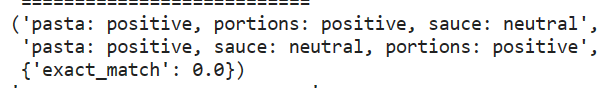

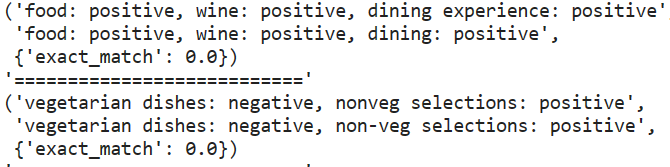

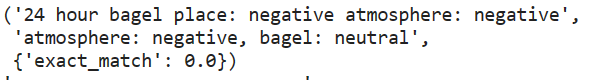

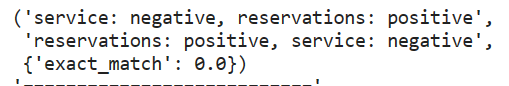

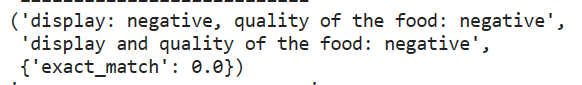

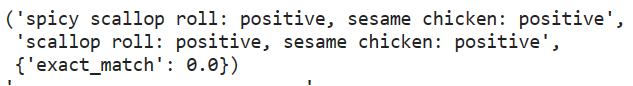

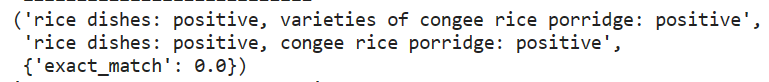


# Финальные выводы

Это самая большая модель, которую я использовала в экспериментах. Она показала лучший результат и самую близкую к benchmark метрику. Подход с помощью промтов является также достаточной универсальным в отношении домена корпуса текстов, так как сами промты имеею общий характер.

Данную методику буду использовать в качестве основной в дальнейших экспериментах.